In [41]:
# Dogs and Cats com Alexnet

![image.png](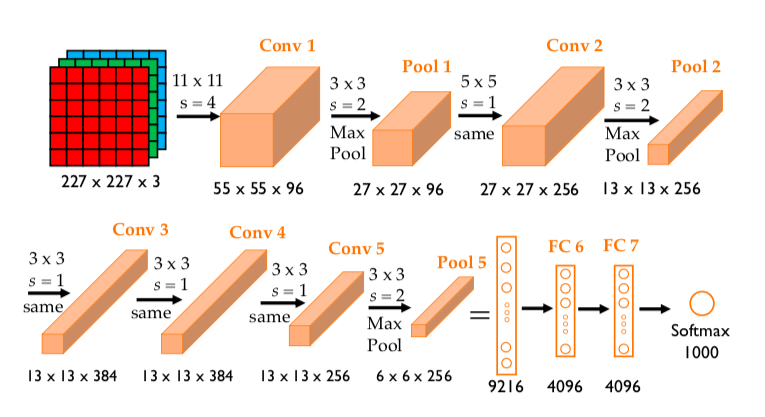)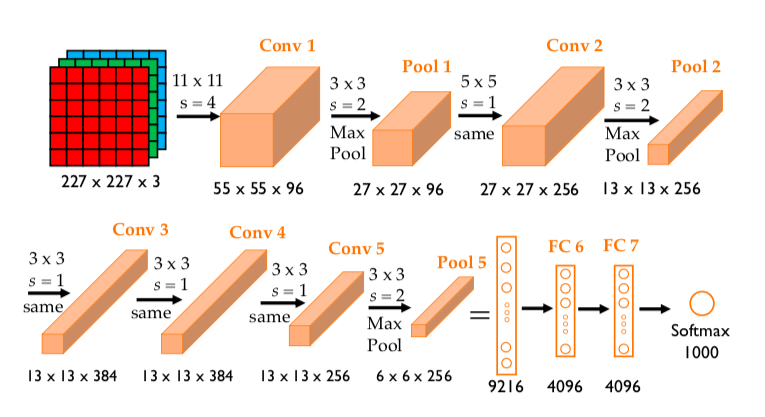

In [42]:
# Extrair os arquivos (Dataset de Cães e Gatos)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import zipfile

with zipfile.ZipFile("/content/drive/MyDrive/CATSANDDOGS/train.zip","r") as z:
    z.extractall(".")

with zipfile.ZipFile("/content/drive/MyDrive/CATSANDDOGS/test1.zip","r") as z:
    z.extractall(".")

In [44]:
import os
import cv2
import time
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import alexnet

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

DIR_TRAIN = "/content/train"
DIR_TEST = "/content/test1"

In [45]:
# Verificando os arquivos
imgs = os.listdir(DIR_TRAIN)
test_imgs = os.listdir(DIR_TEST)

print(imgs[:5])
print(test_imgs[:5])

['dog.1855.jpg', 'cat.9757.jpg', 'cat.1003.jpg', 'cat.8680.jpg', 'cat.9082.jpg']
['12182.jpg', '6946.jpg', '9372.jpg', '9041.jpg', '11159.jpg']


In [46]:
# Distribuição das classes
dogs_list = [img for img in imgs if img.split(".")[0] == "dog"]
cats_list = [img for img in imgs if img.split(".")[0] == "cat"]

print("No of Dogs Images: ",len(dogs_list))
print("No of Cats Images: ",len(cats_list))

class_to_int = {"dog" : 0, "cat" : 1}
int_to_class = {0 : "dog", 1 : "cat"}

No of Dogs Images:  12500
No of Cats Images:  12500


In [47]:
def get_transform():
    return T.Compose([T.ToTensor()])

In [48]:
### Classe de Dataset - Para recuperar imgs e rotulos
class CatDogDataset(Dataset):

    def __init__(self, imgs, class_to_int, mode = "train", transforms = None):

        super().__init__()
        self.imgs = imgs
        self.class_to_int = class_to_int
        self.mode = mode
        self.transforms = transforms

    def __getitem__(self, idx):

        image_name = self.imgs[idx]

        ### Reading, converting and normalizing image
        img = cv2.imread(DIR_TRAIN + image_name, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.

        if self.mode == "train" or self.mode == "val":

            ### Preparing class label
            label = self.class_to_int[image_name.split(".")[0]]
            label = torch.tensor(label, dtype = torch.float32)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label

        elif self.mode == "test":

            ### Apply Transforms on image
            img = self.transforms(img)

            return img


    def __len__(self):
        return len(self.imgs)

In [49]:
#Dividindo os dados do diretorio de treinamento (Treinamento e Validação)
train_imgs, val_imgs = train_test_split(imgs, test_size = 0.25)

In [50]:
### Dataloaders
train_dataset = CatDogDataset(train_imgs, class_to_int, mode = "train", transforms = get_transform())
val_dataset = CatDogDataset(val_imgs, class_to_int, mode = "val", transforms = get_transform())
test_dataset = CatDogDataset(test_imgs, class_to_int, mode = "test", transforms = get_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 4,
    batch_size = 16,
    shuffle = True
)

In [51]:
### Visualizando imagens aleatórias do conjunto de treinamento
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

error: ignored

In [52]:
### GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [53]:
### Modelo Pre-treinado
model = alexnet(pretrained = True)

# Modificando parametros para classificação
model.classifier = nn.Sequential(
    nn.Dropout(0.5, inplace = False),
    nn.Linear(9216, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 1024, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(1024, 1, bias = True),
    nn.Sigmoid()
)

In [54]:
### Definindo os parametros do modelo

# Otimizador
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Taxa de Aprendizado
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)

#Função de Perda
criterion = nn.BCELoss()

# Logs -
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Carregando modelo
model.to(device)

# No de epocas
epochs = 10

In [55]:
### Função para calcular a acurácia
def accuracy(preds, trues):
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]

    ### Calculando a acurácia comparando previsões com rótulos verdadeiros
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]

    acc = np.sum(acc) / len(preds)

    return (acc * 100)

In [56]:
### Função para treinar uma epoca
def train_one_epoch(train_data_loader):

    ### Parametros Locais
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    ###Iteração com dataloader
    for images, labels in train_data_loader:

        #Carregando as imagens
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape

        #Resetando os gradientes
        optimizer.zero_grad()

        #Forward
        preds = model(images)

        #Calculando o erro
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)

        #Calculando a acurácia
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)

        #Backward
        _loss.backward()
        optimizer.step()

    ###Tempo da Epoca
    end_time = time.time()
    total_time = end_time - start_time

    ###Acc and erro
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    ## Histórico de logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)

    return epoch_loss, epoch_acc, total_time

In [57]:
### Função de validação para uma epoca
def val_one_epoch(val_data_loader):

    ### Parametros Locais
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()

    ###Carregando as imagens
    for images, labels in val_data_loader:

        # Carregando as imagens e rótulos
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape

        #Forward
        preds = model(images)

        #Calculando erro
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)

        #Calculando acurácia
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)

    ###Temmpo da epoca
    end_time = time.time()
    total_time = end_time - start_time

    ###Acc e erro
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    ###Histórico de l ogs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)

    return epoch_loss, epoch_acc, total_time

In [58]:
### Treinamento e Validação
for epoch in range(epochs):

    ###Treinamento
    loss, acc, _time = train_one_epoch(train_data_loader)

    #Detalhes da Epoca
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))

    ###Validação
    loss, acc, _time = val_one_epoch(val_data_loader)

    ##Detalhes da Epoca
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))


error: ignored

In [ ]:
### Visualização dos resultados

#Perda - Erro
plt.title("Erro")
plt.plot(np.arange(1, 11, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["loss"], color = 'yellow')
plt.xlabel("Epocas")
plt.ylabel("Erro")
plt.show()

#Acurácia
plt.title("Acurácia")
plt.plot(np.arange(1, 11, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, 11, 1), val_logs["accuracy"], color = 'yellow')
plt.xlabel("Epocas")
plt.ylabel("Acurácia")
plt.show()